Ron Olshansky-Lucero  
Project Luther (web scraping, linear regression)  
07 October 2016

In [2]:
# Python 2/3 compatibility
from __future__ import print_function, division

#
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import RidgeCV

%matplotlib inline

import time
import re
import csv
import pickle
import dateutil.parser
from pprint import pprint

In [3]:
mdf = pd.read_csv('moviedf.csv', index_col=0)
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1368 entries, 0 to 1999
Data columns (total 8 columns):
distributor           1368 non-null object
domestic_adj_gross    1368 non-null float64
genre                 1368 non-null object
mpaa_rating           1368 non-null object
production_budget     1368 non-null float64
release_date          1368 non-null object
runtime_mins          1368 non-null int64
title                 1368 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 96.2+ KB


In [4]:
# rename some variables
mdf = mdf.rename(columns = {'domestic_adj_gross':'gross_adj'})
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1368 entries, 0 to 1999
Data columns (total 8 columns):
distributor          1368 non-null object
gross_adj            1368 non-null float64
genre                1368 non-null object
mpaa_rating          1368 non-null object
production_budget    1368 non-null float64
release_date         1368 non-null object
runtime_mins         1368 non-null int64
title                1368 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 96.2+ KB


In [5]:
type(mdf.release_date)

pandas.core.series.Series

In [6]:
# convert release_date to datetime object
mdf['release_date'] = pd.to_datetime(mdf['release_date'])
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1368 entries, 0 to 1999
Data columns (total 8 columns):
distributor          1368 non-null object
gross_adj            1368 non-null float64
genre                1368 non-null object
mpaa_rating          1368 non-null object
production_budget    1368 non-null float64
release_date         1368 non-null datetime64[ns]
runtime_mins         1368 non-null int64
title                1368 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 96.2+ KB


#### FEATURE ENGINEERING - TRENDS AND SEASONALITY

Generate from `release_date`: `year`, `month`, `day` (all int)

In [7]:
mdf['year'] = mdf['release_date'].dt.year
mdf.year.dtype

dtype('int64')

In [8]:
mdf['month'] = mdf['release_date'].dt.month
mdf.month.dtype

dtype('int64')

In [9]:
mdf['day'] = mdf['release_date'].dt.day
mdf.day.dtype

dtype('int64')

(array([   1.,    0.,    4.,    7.,   11.,   27.,   62.,  238.,  493.,  525.]),
 array([ 1937. ,  1944.9,  1952.8,  1960.7,  1968.6,  1976.5,  1984.4,
         1992.3,  2000.2,  2008.1,  2016. ]),
 <a list of 10 Patch objects>)

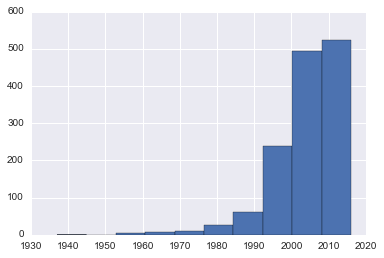

In [10]:
# check distribution of year
plt.hist(mdf.year) # most films in sample from 1990 onward

In [11]:
mdf[mdf.year < 1990].count() # 67 films 

distributor          67
gross_adj            67
genre                67
mpaa_rating          67
production_budget    67
release_date         67
runtime_mins         67
title                67
year                 67
month                67
day                  67
dtype: int64

In [12]:
mdf[mdf.year >= 1990].count() # 1301 films 1990 - 2016 (so far)

distributor          1301
gross_adj            1301
genre                1301
mpaa_rating          1301
production_budget    1301
release_date         1301
runtime_mins         1301
title                1301
year                 1301
month                1301
day                  1301
dtype: int64

In [13]:
# restrict to films 1990 - 2016 (new sample size = 1301)
mdf = mdf[mdf.year >= 1990]
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1301 entries, 0 to 1999
Data columns (total 11 columns):
distributor          1301 non-null object
gross_adj            1301 non-null float64
genre                1301 non-null object
mpaa_rating          1301 non-null object
production_budget    1301 non-null float64
release_date         1301 non-null datetime64[ns]
runtime_mins         1301 non-null int64
title                1301 non-null object
year                 1301 non-null int64
month                1301 non-null int64
day                  1301 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 122.0+ KB


#### Visual Exploration (`year`,`month`,`day`)

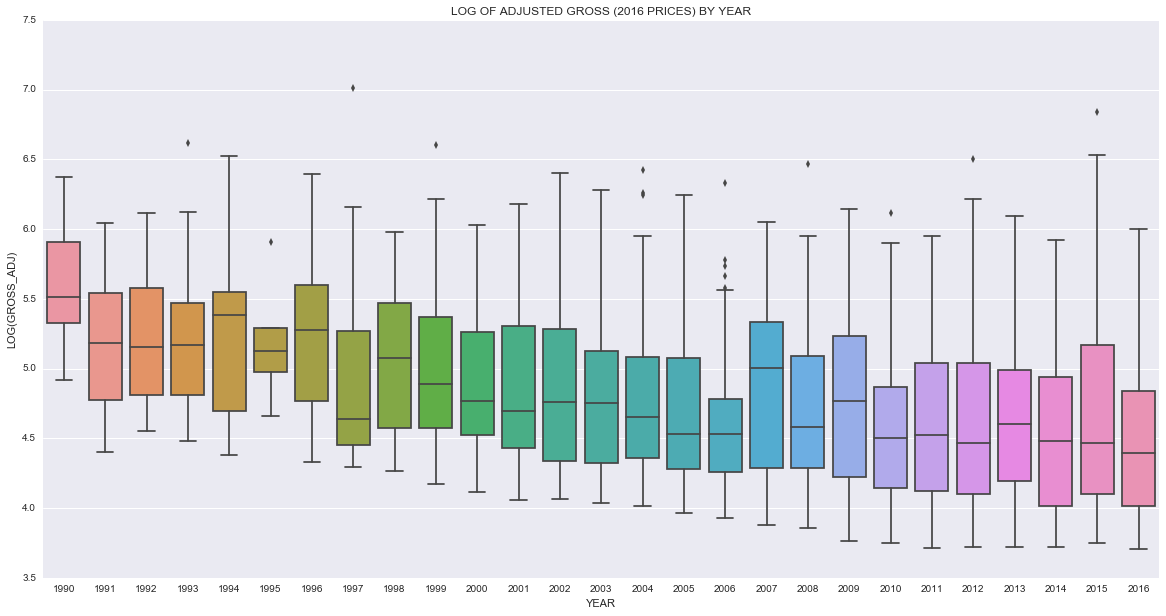

In [14]:
# As time goes on, gross seems to go down
# ==> harder and harder for films to make money
fig, ax = plt.subplots(1,1, figsize = (20, 10))
ax.set_title('LOG OF ADJUSTED GROSS (2016 PRICES) BY YEAR')
sns.boxplot(x = mdf.year.sort_values(),y = np.log(mdf.gross_adj))
ax.set_xlabel('YEAR')
ax.set_ylabel('LOG(GROSS_ADJ)')

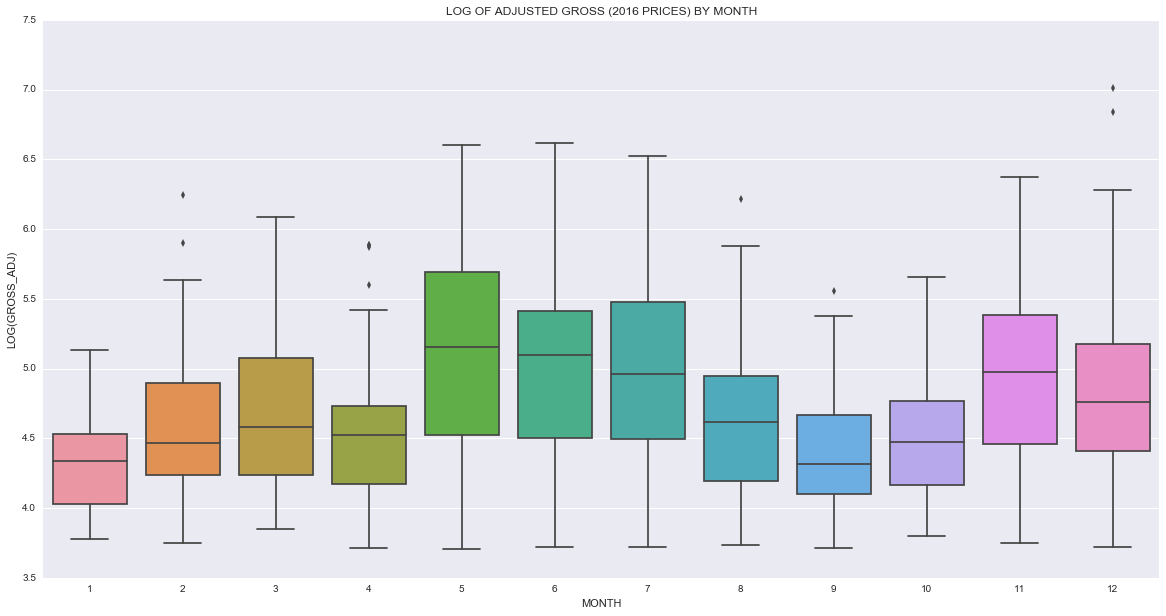

In [15]:
# There is seasonality
# - Summer (May, June, July)
# - Holiday (November, December)
# - Other (rest of year)
fig, ax = plt.subplots(1,1, figsize = (20, 10))
ax.set_title('LOG OF ADJUSTED GROSS (2016 PRICES) BY MONTH')
sns.boxplot(x = mdf.month.sort_values(),y = np.log(mdf.gross_adj))
ax.set_xlabel('MONTH')
ax.set_ylabel('LOG(GROSS_ADJ)')

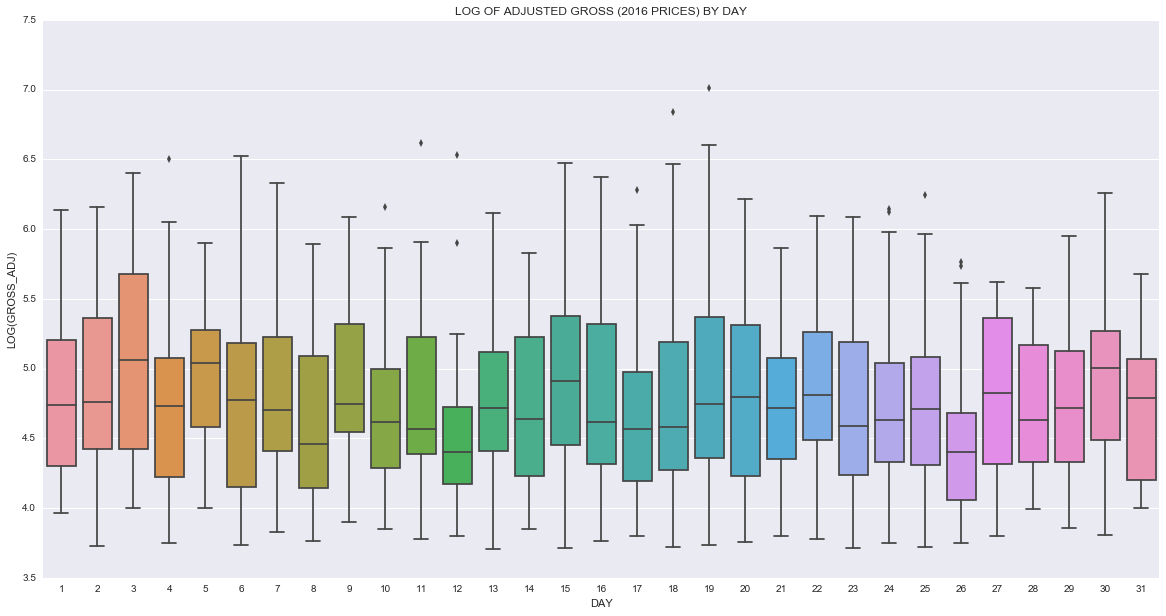

In [16]:
# day of the month does not seems to have a noticeable effect
fig, ax = plt.subplots(1,1, figsize = (20, 10))
ax.set_title('LOG OF ADJUSTED GROSS (2016 PRICES) BY DAY')
sns.boxplot(x = mdf.day.sort_values(),y = np.log(mdf.gross_adj))
ax.set_xlabel('DAY')
ax.set_ylabel('LOG(GROSS_ADJ)')

From above, there is a need to construct indicator variables to reflect season.
- `summer` (May, June, July)
- `holiday` (November, December)
- `offseason` (rest of year)

In [17]:
# initialise variables
mdf['summer'] = 0
mdf['holiday'] = 0
mdf['offseason'] = 0

# assign values
mdf['summer'] = mdf.month.map(lambda x: 1 if (5 <= x <= 7) else 0)
mdf['holiday'] = mdf.month.map(lambda x: 1 if (11 <= x <= 12) else 0)
mdf['offseason'] = mdf.month.map(lambda x: 1 if x in [1,2,3,4,8,9,10] else 0)

In [18]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1301 entries, 0 to 1999
Data columns (total 14 columns):
distributor          1301 non-null object
gross_adj            1301 non-null float64
genre                1301 non-null object
mpaa_rating          1301 non-null object
production_budget    1301 non-null float64
release_date         1301 non-null datetime64[ns]
runtime_mins         1301 non-null int64
title                1301 non-null object
year                 1301 non-null int64
month                1301 non-null int64
day                  1301 non-null int64
summer               1301 non-null int64
holiday              1301 non-null int64
offseason            1301 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(7), object(4)
memory usage: 152.5+ KB


In [19]:
# there is definitely a relationship with summer and offseason, not so much holiday
mdf.corr()['gross_adj'].sort_values(ascending=False)

gross_adj            1.000000
production_budget    0.433083
runtime_mins         0.288056
summer               0.255784
holiday              0.078535
month                0.066616
day                 -0.039630
year                -0.219817
offseason           -0.308781
Name: gross_adj, dtype: float64

For seasonality, the correlation seems strongest between `gross_adj` and `offseason`, followed by correlation between `gross_adj` and `summer`. The weakest correlation seems to be between `gross_adj` and `holiday`.

#### FEATURE ENGINEERING - INFLATION ADJUSTMENTS

Unlike the `gross_adj` figures, the `production_budget` figures are unadjusted. `gross_adj` was adjusted to be equivalent with the gross revenue based on 2016 average ticket prices. This computation was already done by the data source. 

It is not possible to do the same extrapolation with budget figures. Instead, the budget figures can be adjusted using the CPI as an inflation adjuster.

A dictionary is constructed with the help of the the BLS' CPI Inflation Calculator, which was used to compute the equivalence of $1 to 2016 dollars for every year from 1990 to 2016 (27 years). A function was then mapped to a new variable, `budget_adj`.

In [20]:
# inflation adjuster (for production budget)
def inflation_adjuster(year):
    '''
    source: http://data.bls.gov/cgi-bin/cpicalc.pl
    retrieved 6 Oct 2016
    '''
    yr_list = list(mdf.year.unique())
    yr_list.sort()
    cpi_inflation = [1.84, 1.77, 1.72, 1.67, 1.63, 1.58, 1.54, 1.50, 1.48, 1.45, 1.40, 1.36, 1.34, 1.31, 1.28, 1.23, 1.19, 1.16, 1.12, 1.12, 1.10, 1.07, 1.05, 1.03, 1.02, 1.02, 1.00]
    inflation_dict = dict(zip(yr_list, cpi_inflation))
    return inflation_dict.get(year)

In [21]:
# test
print(inflation_adjuster(1990)) # 1.84
print(inflation_adjuster(2003)) # 1.31
print(inflation_adjuster(2016)) # 1.0

1.84
1.31
1.0


In [22]:
# create inflation adjuster variable
mdf['inf_adj'] = mdf.year.map(inflation_adjuster)
mdf.inf_adj.describe()

count    1301.000000
mean        1.232798
std         0.198007
min         1.000000
25%         1.070000
50%         1.190000
75%         1.360000
max         1.840000
Name: inf_adj, dtype: float64

In [23]:
# create adjusted budget variable
mdf['budget_adj'] = mdf.production_budget*mdf.inf_adj
mdf.budget_adj.describe()

count    1301.000000
mean       83.121972
std        59.154938
min         0.016800
25%        36.900000
50%        68.250000
75%       117.600000
max       348.000000
Name: budget_adj, dtype: float64

In [24]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1301 entries, 0 to 1999
Data columns (total 16 columns):
distributor          1301 non-null object
gross_adj            1301 non-null float64
genre                1301 non-null object
mpaa_rating          1301 non-null object
production_budget    1301 non-null float64
release_date         1301 non-null datetime64[ns]
runtime_mins         1301 non-null int64
title                1301 non-null object
year                 1301 non-null int64
month                1301 non-null int64
day                  1301 non-null int64
summer               1301 non-null int64
holiday              1301 non-null int64
offseason            1301 non-null int64
inf_adj              1301 non-null float64
budget_adj           1301 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(7), object(4)
memory usage: 172.8+ KB


In [25]:
len(mdf.distributor.unique())

45

#### FEATURE ENGINEERING - MARKET SHARES (DISTRIBUTOR AND GENRE)

Differences in gross revenues are expected among different distributors and different genres.

As can be seen below, there are 45 distinct distributors and 60 distinct genres. However, it is possible to reduce dimensionality by further grouping distributors and genres.

To facilitate this, distributors and genres are compared by market share (defined as adjusted gross revenues for the whole sample period).

Distributors can be grouped by relative market shares to determine an appropriate grouping (small, medium, large distributors).

Genres are first broadly classified, and the broad groups are compared based on market share. 

In [26]:
print(len(mdf.distributor.unique())) # 45 studios
print(len(mdf.genre.unique())) # 60 genres

45
60


In [27]:
mdf.gross_adj.sum()

190523.66999999963

In [28]:
dict(mdf.groupby('distributor').gross_adj.sum().sort_values(ascending=False)/mdf.gross_adj.sum())

{'Artisan': 0.0012574836501942277,
 'Buena Vista': 0.15488245948653023,
 'CBS Films': 0.00034831315185142157,
 'Columbia': 0.0067322049800951382,
 'Dimension Films': 0.0066239391672436431,
 'DreamWorks': 0.02872835275532962,
 'FilmDistrict': 0.0015838263035768761,
 'Focus Features': 0.0037049533005531613,
 'Fox': 0.1244002123200758,
 'Fox Searchlight': 0.0060878336009378906,
 'Freestyle Releasing': 0.00033484238467587846,
 'Gramercy': 0.0010218604334044183,
 'IFC': 0.001882667387207063,
 'Lions Gate': 0.0029678732306594822,
 'Lionsgate': 0.014482834600026367,
 'Lionsgate/Summit': 0.0053708733408295252,
 'MGM': 0.011404292705468061,
 'MGM (Weinstein)': 0.00047558290263881742,
 'Miramax': 0.015339233702563074,
 'New Line': 0.036584873155130863,
 'Newmarket': 0.0027101997352874897,
 'Open Road Films': 0.0011268573610827483,
 'Orion Pictures': 0.0033978717709983292,
 'Overture Films': 0.00091543166263803523,
 'Paramount': 0.10840654602128987,
 'Paramount (DreamWorks)': 0.025052680855874802

In [29]:
# mdf.groupby('distributor').gross_adj.sum().sort_values(ascending=False)/mdf.gross_adj.sum()

In [30]:
def dist_dollar_share(distributor):
    dollar_dict = dict(mdf.groupby('distributor').gross_adj.sum().sort_values(ascending=False)/mdf.gross_adj.sum())
    return dollar_dict.get(distributor)*100

In [31]:
dist_dollar_share('Universal')

12.628327388402738

In [32]:
# # function to compute distributor's market share (dollar)
# def dist_dollar_share(distributor):
#     dollarshare_dict = (mdf.groupby('distributor')['distributor'].count()/len(mdf)).to_dict()
#     return countshare_dict.get(distributor)*100

In [33]:
# construct a variable for distributor market share
mdf['dist_mktshare'] = mdf.distributor.map(dist_dollar_share)

/Users/rol-mbp/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


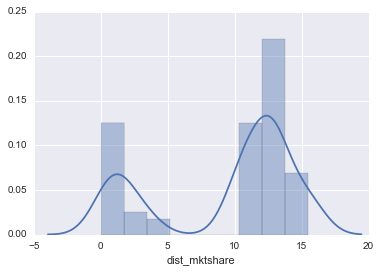

In [34]:
sns.distplot(mdf.dist_mktshare);

There are at least 2 distinct groups of distributors based on market share.

The first group is one with relatively smaller market share (less than 7%), whilst the second group has considerably larger market share.

From this, two indicator variables are created:
- `lg_dist` (market share > 8%)
- `sm_dist` (market share < 8%)


In [35]:
# initialise variables
mdf['lg_dist'] = 0
mdf['sm_dist'] = 0

# assign values
mdf['lg_dist'] = mdf.dist_mktshare.map(lambda x: 1 if (x > 8.0) else 0)
mdf['sm_dist'] = mdf.dist_mktshare.map(lambda x: 1 if (x < 8.0) else 0)

In [36]:
mdf[mdf.lg_dist == 1].count(); # 924 large distributors
mdf[mdf.sm_dist == 1].count(); # 377 large distributors

In [37]:
mdf.corr()['gross_adj'].sort_values(ascending=False)

gross_adj            1.000000
budget_adj           0.485022
production_budget    0.433083
runtime_mins         0.288056
summer               0.255784
inf_adj              0.234022
dist_mktshare        0.157432
lg_dist              0.117080
holiday              0.078535
month                0.066616
day                 -0.039630
sm_dist             -0.117080
year                -0.219817
offseason           -0.308781
Name: gross_adj, dtype: float64

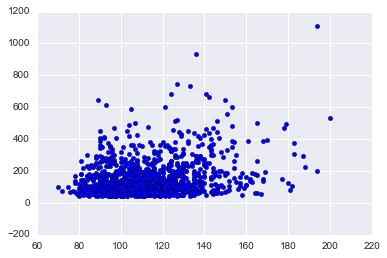

In [38]:
plt.scatter(mdf.runtime_mins,mdf.gross_adj)

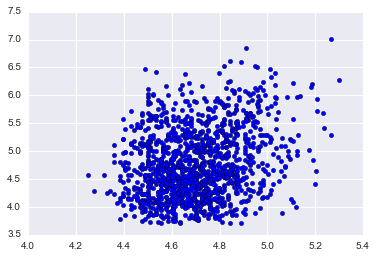

In [39]:
plt.scatter(np.log(mdf.runtime_mins),np.log(mdf.gross_adj))

In [40]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1301 entries, 0 to 1999
Data columns (total 19 columns):
distributor          1301 non-null object
gross_adj            1301 non-null float64
genre                1301 non-null object
mpaa_rating          1301 non-null object
production_budget    1301 non-null float64
release_date         1301 non-null datetime64[ns]
runtime_mins         1301 non-null int64
title                1301 non-null object
year                 1301 non-null int64
month                1301 non-null int64
day                  1301 non-null int64
summer               1301 non-null int64
holiday              1301 non-null int64
offseason            1301 non-null int64
inf_adj              1301 non-null float64
budget_adj           1301 non-null float64
dist_mktshare        1301 non-null float64
lg_dist              1301 non-null int64
sm_dist              1301 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(9), object(4)
memory usage: 203.3+ KB


In [43]:
dict(mdf.groupby('genre').gross_adj.sum().sort_values(ascending=False)/mdf.gross_adj.sum())

{'Action': 0.049915541727702489,
 'Action / Adventure': 0.080484983834292242,
 'Action / Crime': 0.0023562872791606459,
 'Action Comedy': 0.028278348826683904,
 'Action Drama': 0.013083698734125819,
 'Action Fantasy': 0.00071229312347384586,
 'Action Horror': 0.0087472039563378338,
 'Action Thriller': 0.027614455463722754,
 'Adventure': 0.012561732618314586,
 'Adventure Comedy': 0.00083008058788706051,
 'Animation': 0.11950663138076256,
 'Comedy': 0.10312765600200771,
 'Comedy / Drama': 0.01886097617162218,
 'Concert': 0.00032199411233260473,
 'Crime': 0.0046512378225760697,
 'Crime Comedy': 0.0069150237343213183,
 'Crime Drama': 0.0098090326519534501,
 'Crime Thriller': 0.0011776898901853005,
 'Documentary': 0.0012946711555577345,
 'Drama': 0.028499330818055387,
 'Drama / Thriller': 0.010849235688143126,
 'Family': 0.0029565077137134778,
 'Family Adventure': 0.023737676268780716,
 'Family Comedy': 0.032986245750987318,
 'Fantasy': 0.033598525579525168,
 'Fantasy Comedy': 0.00860175956

In [99]:
# function to compute market share of major genre
def g_dollar_share(genre):
    dollar_dict = dict(mdf.groupby('genre').gross_adj.sum().sort_values(ascending=False)/mdf.gross_adj.sum())
    return dollar_dict.get(genre)*100

In [100]:
# test
g_dollar_share('Action / Adventure')

8.0484983834292247

Regroup the 60 `genre` into a smaller space of `major_genre`.

In [44]:
def reduce_genre(genre):
    genre_dict = {'Action':'action_adventure',
              'Action / Adventure':'action_adventure',
              'Action / Crime':'action_adventure',
              'Action Comedy':'action_adventure',
              'Action Drama':'action_adventure',
              'Action Fantasy':'action_adventure',
              'Action Horror':'action_adventure',
              'Action Thriller':'action_adventure',
              'Adventure':'action_adventure',
              'Adventure Comedy':'action_adventure',
              'Animation':'animation',
              'Comedy':'comedy',
              'Comedy / Drama':'comedy',
              'Crime Comedy':'comedy',
              'Fantasy Comedy':'comedy',
              'Horror Comedy':'comedy',
              'Sports Comedy':'comedy',
              'Crime':'crime_thriller',
              'Crime Drama':'crime_thriller',
              'Crime Thriller':'crime_thriller',
              'Thriller':'crime_thriller',
              'Drama':'drama',
              'Drama / Thriller':'drama',
              'Sports Drama':'drama',
              'Family':'family',
              'Family Adventure':'family',
              'Family Comedy':'family',
              'Fantasy':'fantasy',
              'Fantasy Drama':'fantasy',
              'Historical Drama':'historical_period',
              'Historical Epic':'historical_period',
              'Period Action':'historical_period',
              'Period Adventure':'historical_period',
              'Period Comedy':'historical_period',
              'Period Drama':'historical_period',
              'Period Horror':'historical_period',
              'Horror':'horror',
              'Horror Thriller':'horror',
              'Romance':'romantic',
              'Romantic Adventure':'romantic',
              'Romantic Comedy':'romantic',
              'Romantic Thriller':'romantic',
              'Sci-Fi':'sci_fi',
              'Sci-Fi Action':'sci_fi',
              'Sci-Fi Adventure':'sci_fi',
              'Sci-Fi Comedy':'sci_fi',
              'Sci-Fi Fantasy':'sci_fi',
               'Sci-Fi Horror':'sci_fi',
              'Sci-Fi Thriller':'sci_fi',
              'War':'war',
              'War Drama':'war',
              'War Romance':'war',
              'Western':'western',
              'Western Comedy':'western',
              'Concert':'other',
              'Documentary':'other',
              'Foreign / Action':'other',
              'IMAX':'other',
              'Music Drama':'other',
              'Musical':'other'}
    return genre_dict.get(genre)

In [45]:
# test function
reduce_genre('IMAX')

'other'

In [46]:
mdf['major_genre'] =  mdf.genre.map(reduce_genre)

In [47]:
mdf.major_genre.unique()

array(['sci_fi', 'romantic', 'action_adventure', 'animation',
       'historical_period', 'fantasy', 'drama', 'family', 'comedy',
       'horror', 'crime_thriller', 'war', 'western', 'other'], dtype=object)

In [48]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1301 entries, 0 to 1999
Data columns (total 20 columns):
distributor          1301 non-null object
gross_adj            1301 non-null float64
genre                1301 non-null object
mpaa_rating          1301 non-null object
production_budget    1301 non-null float64
release_date         1301 non-null datetime64[ns]
runtime_mins         1301 non-null int64
title                1301 non-null object
year                 1301 non-null int64
month                1301 non-null int64
day                  1301 non-null int64
summer               1301 non-null int64
holiday              1301 non-null int64
offseason            1301 non-null int64
inf_adj              1301 non-null float64
budget_adj           1301 non-null float64
dist_mktshare        1301 non-null float64
lg_dist              1301 non-null int64
sm_dist              1301 non-null int64
major_genre          1301 non-null object
dtypes: datetime64[ns](1), float64(5), int64(9), 

With a narrower `major_genre` grouping, a variable for mg_mktshare is constructed.

In [49]:
# function to compute market share of major genre
def mg_dollar_share(major_genre):
    dollar_dict = dict(mdf.groupby('major_genre').gross_adj.sum().sort_values(ascending=False)/mdf.gross_adj.sum())
    return dollar_dict.get(major_genre)*100

In [50]:
mdf['mg_mktshare'] = mdf.major_genre.map(mg_dollar_share)

In [51]:
mdf.mg_mktshare.describe()

count    1301.000000
mean       11.340233
std         6.916203
min         0.942155
25%         5.244873
50%        10.337070
75%        15.433758
max        22.458463
Name: mg_mktshare, dtype: float64

/Users/rol-mbp/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


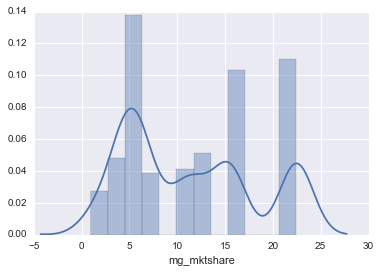

In [52]:
sns.distplot(mdf.mg_mktshare);

In [53]:
mdf.groupby('major_genre').gross_adj.sum().sort_values(ascending=False)/mdf.gross_adj.sum()

major_genre
action_adventure     0.224585
comedy               0.154338
animation            0.119507
sci_fi               0.103371
romantic             0.069373
family               0.059680
drama                0.052449
crime_thriller       0.050774
historical_period    0.050132
fantasy              0.039067
horror               0.035898
other                0.016102
war                  0.015303
western              0.009422
Name: gross_adj, dtype: float64

Looking at the distribution of market shares for major genres, it is much harder to delineate a separation of groups.

This is because there are only a few genres that tend to always do well - Action/Adventure, Comedy, Animation, and Sci-Fi seem to be the major genres that account for 60% of gross revenues.

Apart from comedy, all these genres are generally known to be expensive to produce, based on the required special effects.


It may be useful to lump together all the other genres except for the top four into one category called `specialty_genre`, an indicator variable which equals 1 when the major_genre's market share is less than 10% (i.e. those other than `action_adventure`, `comedy`, `animation`, or `sci_fi`).

In [54]:
# construct indicator for `specialty_genre`
mdf['specialty_genre'] = 0 # initialise variable
mdf['specialty_genre'] = mdf.mg_mktshare.map(lambda x: 1 if x < 10 else 0)

In [55]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1301 entries, 0 to 1999
Data columns (total 22 columns):
distributor          1301 non-null object
gross_adj            1301 non-null float64
genre                1301 non-null object
mpaa_rating          1301 non-null object
production_budget    1301 non-null float64
release_date         1301 non-null datetime64[ns]
runtime_mins         1301 non-null int64
title                1301 non-null object
year                 1301 non-null int64
month                1301 non-null int64
day                  1301 non-null int64
summer               1301 non-null int64
holiday              1301 non-null int64
offseason            1301 non-null int64
inf_adj              1301 non-null float64
budget_adj           1301 non-null float64
dist_mktshare        1301 non-null float64
lg_dist              1301 non-null int64
sm_dist              1301 non-null int64
major_genre          1301 non-null object
mg_mktshare          1301 non-null float64
specia

#### FEATURE ENGINEERING - RECODING MPAA RATINGS

MPAA ratings can be recoded to reflect the level of restriction numerically.

G = 1, PG = 2, PG-13 = 3, R = 4


In [56]:
# function to map
def recode_mpaa(rtg):
    rtg_dict = {'G':1,'PG':2,'PG-13':3,'R':4}
    return rtg_dict.get(rtg)

In [57]:
# test function
recode_mpaa('R')

4

In [58]:
mdf['rtg_restrict'] = mdf.mpaa_rating.map(recode_mpaa)

In [59]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1301 entries, 0 to 1999
Data columns (total 23 columns):
distributor          1301 non-null object
gross_adj            1301 non-null float64
genre                1301 non-null object
mpaa_rating          1301 non-null object
production_budget    1301 non-null float64
release_date         1301 non-null datetime64[ns]
runtime_mins         1301 non-null int64
title                1301 non-null object
year                 1301 non-null int64
month                1301 non-null int64
day                  1301 non-null int64
summer               1301 non-null int64
holiday              1301 non-null int64
offseason            1301 non-null int64
inf_adj              1301 non-null float64
budget_adj           1301 non-null float64
dist_mktshare        1301 non-null float64
lg_dist              1301 non-null int64
sm_dist              1301 non-null int64
major_genre          1301 non-null object
mg_mktshare          1301 non-null float64
specia

In [60]:
mdf.corr()['gross_adj'].abs().sort_values(ascending = False)

gross_adj            1.000000
budget_adj           0.485022
production_budget    0.433083
offseason            0.308781
runtime_mins         0.288056
summer               0.255784
inf_adj              0.234022
year                 0.219817
rtg_restrict         0.159000
dist_mktshare        0.157432
specialty_genre      0.142480
lg_dist              0.117080
sm_dist              0.117080
mg_mktshare          0.103731
holiday              0.078535
month                0.066616
day                  0.039630
Name: gross_adj, dtype: float64

In [61]:
mdf.corr()['gross_adj'].sort_values(ascending=False)

gross_adj            1.000000
budget_adj           0.485022
production_budget    0.433083
runtime_mins         0.288056
summer               0.255784
inf_adj              0.234022
dist_mktshare        0.157432
lg_dist              0.117080
mg_mktshare          0.103731
holiday              0.078535
month                0.066616
day                 -0.039630
sm_dist             -0.117080
specialty_genre     -0.142480
rtg_restrict        -0.159000
year                -0.219817
offseason           -0.308781
Name: gross_adj, dtype: float64

In [62]:
mdf[['gross_adj','specialty_genre']].corr()

,gross_adj,specialty_genre
gross_adj,1.00000,-0.14248
specialty_genre,-0.14248,1.00000


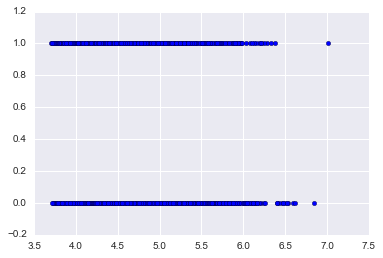

In [63]:
plt.scatter(np.log(mdf.gross_adj), (mdf.specialty_genre))

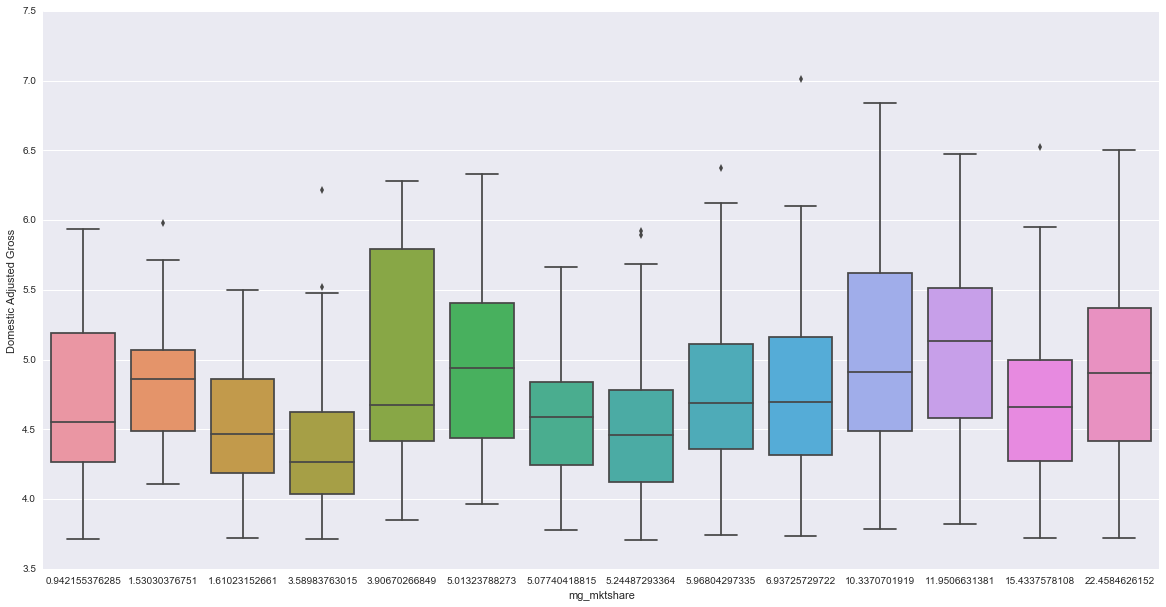

In [64]:
fig, ax = plt.subplots(1,1, figsize = (20, 10))
# ax.set_title('Domestic Adjusted Gross (2016 prices) by Month')
sns.boxplot(x = mdf.mg_mktshare.sort_values(),y = np.log(mdf.gross_adj))
# ax.set_xlabel('Month')
ax.set_ylabel('Domestic Adjusted Gross')

In [65]:
major_genre_dummies = pd.get_dummies(mdf.major_genre, prefix = 'mg')

In [66]:
mdf2 = pd.concat([mdf,major_genre_dummies], axis = 1)

In [67]:
mdf2.corr()['gross_adj'].abs().sort_values(ascending=False)

gross_adj               1.000000
budget_adj              0.485022
production_budget       0.433083
offseason               0.308781
runtime_mins            0.288056
summer                  0.255784
inf_adj                 0.234022
year                    0.219817
rtg_restrict            0.159000
dist_mktshare           0.157432
mg_sci_fi               0.149252
specialty_genre         0.142480
mg_animation            0.128294
mg_horror               0.123086
lg_dist                 0.117080
sm_dist                 0.117080
mg_drama                0.107674
mg_comedy               0.104929
mg_mktshare             0.103731
mg_crime_thriller       0.095662
mg_action_adventure     0.089597
holiday                 0.078535
mg_fantasy              0.077225
month                   0.066616
mg_other                0.061138
mg_historical_period    0.051506
day                     0.039630
mg_western              0.017123
mg_family               0.009942
mg_romantic             0.001014
mg_war    

In [68]:
mdf.corr()['gross_adj'].abs().sort_values(ascending=False)

gross_adj            1.000000
budget_adj           0.485022
production_budget    0.433083
offseason            0.308781
runtime_mins         0.288056
summer               0.255784
inf_adj              0.234022
year                 0.219817
rtg_restrict         0.159000
dist_mktshare        0.157432
specialty_genre      0.142480
lg_dist              0.117080
sm_dist              0.117080
mg_mktshare          0.103731
holiday              0.078535
month                0.066616
day                  0.039630
Name: gross_adj, dtype: float64

In [69]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1301 entries, 0 to 1999
Data columns (total 23 columns):
distributor          1301 non-null object
gross_adj            1301 non-null float64
genre                1301 non-null object
mpaa_rating          1301 non-null object
production_budget    1301 non-null float64
release_date         1301 non-null datetime64[ns]
runtime_mins         1301 non-null int64
title                1301 non-null object
year                 1301 non-null int64
month                1301 non-null int64
day                  1301 non-null int64
summer               1301 non-null int64
holiday              1301 non-null int64
offseason            1301 non-null int64
inf_adj              1301 non-null float64
budget_adj           1301 non-null float64
dist_mktshare        1301 non-null float64
lg_dist              1301 non-null int64
sm_dist              1301 non-null int64
major_genre          1301 non-null object
mg_mktshare          1301 non-null float64
specia

In [70]:
# try fitting a model with mdf

# reference levels (to exclude)
# - summer (seasonality)
# - lg_dist (dist mktshare)

subcols1 = ['gross_adj','budget_adj','runtime_mins','year','rtg_restrict',
            'specialty_genre','dist_mktshare','lg_dist','sm_dist',
            'offseason','summer','holiday']

df1 = mdf[subcols1]

y,X = patsy.dmatrices('''np.log(gross_adj) ~ 
budget_adj + runtime_mins + year + rtg_restrict + sm_dist + 
specialty_genre + offseason + holiday''', 
                      data = df1,
                     return_type = 'dataframe')

In [71]:
# split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

In [72]:
# train model1
model1 = sm.OLS(y_train, X_train)
res1 = model1.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(gross_adj)   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     61.40
Date:                Fri, 07 Oct 2016   Prob (F-statistic):           4.98e-80
Time:                        06:35:37   Log-Likelihood:                -634.05
No. Observations:                 910   AIC:                             1286.
Df Residuals:                     901   BIC:                             1329.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          53.6202      5.092     10.530      0.000        43.627    63.614
budget_adj          0.0036      0.000     10.500      0.000         0.003     0.004
runtime_mins        0.0050      0.001      4.986      0.000         0.003     0.007
year               -0.0246      0.003     -9.691      0.000        -0.030    -0.020
rtg_restrict       -0.0994      0.023     -4.327      0.000        -0.145    -0.054
sm_dist             0.0509      0.037      1.363      0.173        -0.022     0.124
specialty_genre    -0.1266      0.035     -3.592      0.000        -0.196    -0.057
offseason          -0.1390      0.040     -3.436      0.001        -0.218    -0.060
holiday            -0.0212      0.046     -0.459      0.646        -0.112     0.069
==============================================================================
Omnibus:                       20.705   Durbin-Watson:                   2.134
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.662
Skew:                           0.377   Prob(JB):                     1.98e-05
Kurtosis:                       3.038   Cond. No.                     6.33e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [73]:
# test model1
model1 = sm.OLS(y_test, X_test)
res1 = model1.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(gross_adj)   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     46.41
Date:                Fri, 07 Oct 2016   Prob (F-statistic):           6.93e-52
Time:                        06:35:37   Log-Likelihood:                -248.88
No. Observations:                 391   AIC:                             515.8
Df Residuals:                     382   BIC:                             551.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          69.5464      7.455      9.329      0.000        54.889    84.204
budget_adj          0.0038      0.001      7.550      0.000         0.003     0.005
runtime_mins        0.0061      0.001      4.077      0.000         0.003     0.009
year               -0.0325      0.004     -8.735      0.000        -0.040    -0.025
rtg_restrict       -0.0913      0.033     -2.797      0.005        -0.155    -0.027
sm_dist            -0.0384      0.055     -0.701      0.484        -0.146     0.069
specialty_genre    -0.1722      0.051     -3.359      0.001        -0.273    -0.071
offseason          -0.2980      0.058     -5.101      0.000        -0.413    -0.183
holiday            -0.2449      0.064     -3.823      0.000        -0.371    -0.119
==============================================================================
Omnibus:                        4.290   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.117   Jarque-Bera (JB):                4.284
Skew:                           0.256   Prob(JB):                        0.117
Kurtosis:                       2.963   Cond. No.                     6.41e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [74]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1301 entries, 0 to 1999
Data columns (total 12 columns):
gross_adj          1301 non-null float64
budget_adj         1301 non-null float64
runtime_mins       1301 non-null int64
year               1301 non-null int64
rtg_restrict       1301 non-null int64
specialty_genre    1301 non-null int64
dist_mktshare      1301 non-null float64
lg_dist            1301 non-null int64
sm_dist            1301 non-null int64
offseason          1301 non-null int64
summer             1301 non-null int64
holiday            1301 non-null int64
dtypes: float64(3), int64(9)
memory usage: 132.1 KB


In [75]:
# explore possible interactions

# check some pairwise correlations
# df1[['budget_adj','runtime_mins']].corr()
df1.corr()

# budget-runtime: 0.35
# budget-distributor_mktshare: 0.31
# budget-offseason (negative): -0.36 numeric-factor
# budget-summer: 0.31 numeric-factor

# runtime-rtg_restrict: 0.28

,gross_adj,budget_adj,runtime_mins,year,rtg_restrict,specialty_genre,dist_mktshare,lg_dist,sm_dist,offseason,summer,holiday
gross_adj,1.000000,0.485022,0.288056,-0.219817,-0.159000,-0.142480,0.157432,0.117080,-0.117080,-0.308781,0.255784,0.078535
budget_adj,0.485022,1.000000,0.349469,0.015699,-0.212667,-0.221605,0.313380,0.279927,-0.279927,-0.355419,0.309077,0.074017
runtime_mins,0.288056,0.349469,1.000000,-0.043319,0.284374,0.187728,0.096729,0.100415,-0.100415,-0.218845,0.054292,0.197565
year,-0.219817,0.015699,-0.043319,1.000000,-0.022353,-0.096797,-0.027855,-0.002349,0.002349,0.116467,-0.022733,-0.112026
rtg_restrict,-0.159000,-0.212667,0.284374,-0.022353,1.000000,0.095000,-0.216427,-0.148271,0.148271,0.108154,-0.044994,-0.077342
specialty_genre,-0.142480,-0.221605,0.187728,-0.096797,0.095000,1.000000,-0.098150,-0.104212,0.104212,0.077859,-0.170470,0.098615
dist_mktshare,0.157432,0.313380,0.096729,-0.027855,-0.216427,-0.098150,1.000000,0.958225,-0.958225,-0.152479,0.135749,0.028233
lg_dist,0.117080,0.279927,0.100415,-0.002349,-0.148271,-0.104212,0.958225,1.000000,-1.000000,-0.150025,0.134481,0.026754
sm_dist,-0.117080,-0.279927,-0.100415,0.002349,0.148271,0.104212,-0.958225,-1.000000,1.000000,0.150025,-0.134481,-0.026754
offseason,-0.308781,-0.355419,-0.218845,0.116467,0.108154,0.077859,-0.152479,-0.150025,0.150025,1.000000,-0.622275,-0.484633


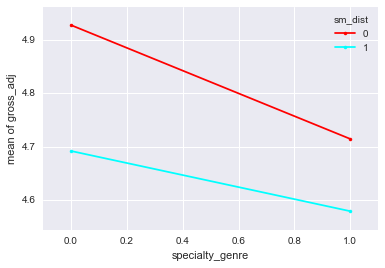

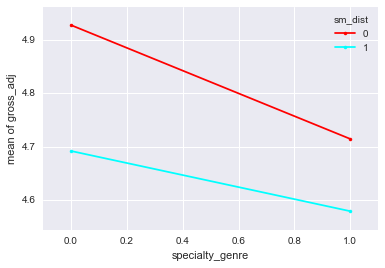

In [76]:

# interaction_plot(x, trace, response, xlabel, ylabel, legend)
from statsmodels.graphics.api import interaction_plot, abline_plot
interaction_plot(df1.specialty_genre, df1.sm_dist, np.log(df1.gross_adj))

In [77]:
# model 2 with interactions

y2,X2 = patsy.dmatrices('''np.log(gross_adj) ~ 
budget_adj + runtime_mins + budget_adj*runtime_mins + year + rtg_restrict + sm_dist + 
specialty_genre + offseason + holiday + budget_adj*offseason''', 
                      data = df1,
                     return_type = 'dataframe')

In [78]:
# split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,test_size = 0.3)

In [79]:
# train model2
model2 = sm.OLS(y2_train, X2_train)
res2 = model2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(gross_adj)   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     54.79
Date:                Fri, 07 Oct 2016   Prob (F-statistic):           4.62e-86
Time:                        06:35:37   Log-Likelihood:                -618.40
No. Observations:                 910   AIC:                             1259.
Df Residuals:                     899   BIC:                             1312.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                  59.6858      4.960     12.032      0.000        49.950    69.421
budget_adj                  0.0031      0.002      1.973      0.049      1.64e-05     0.006
runtime_mins                0.0049      0.002      3.102      0.002         0.002     0.008
budget_adj:runtime_mins  4.153e-06   1.26e-05      0.329      0.742     -2.06e-05  2.89e-05
year                       -0.0276      0.002    -11.163      0.000        -0.032    -0.023
rtg_restrict               -0.0891      0.023     -3.942      0.000        -0.133    -0.045
sm_dist                     0.0324      0.037      0.883      0.378        -0.040     0.104
specialty_genre            -0.1553      0.035     -4.443      0.000        -0.224    -0.087
offseason                  -0.1626      0.064     -2.541      0.011        -0.288    -0.037
holiday                    -0.1156      0.045     -2.546      0.011        -0.205    -0.026
budget_adj:offseason       -0.0003      0.001     -0.425      0.671        -0.002     0.001
==============================================================================
Omnibus:                       21.171   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.119
Skew:                           0.380   Prob(JB):                     1.57e-05
Kurtosis:                       3.074   Cond. No.                     3.88e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.88e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [80]:
# test model2
model2 = sm.OLS(y2_test, X2_test)
res2 = model2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(gross_adj)   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     27.92
Date:                Fri, 07 Oct 2016   Prob (F-statistic):           6.67e-40
Time:                        06:35:37   Log-Likelihood:                -271.74
No. Observations:                 391   AIC:                             565.5
Df Residuals:                     380   BIC:                             609.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                  58.7720      8.110      7.247      0.000        42.826    74.718
budget_adj                  0.0017      0.002      0.752      0.452        -0.003     0.006
runtime_mins                0.0031      0.002      1.247      0.213        -0.002     0.008
budget_adj:runtime_mins  1.875e-05   1.84e-05      1.018      0.309     -1.75e-05   5.5e-05
year                       -0.0270      0.004     -6.697      0.000        -0.035    -0.019
rtg_restrict               -0.1146      0.035     -3.279      0.001        -0.183    -0.046
sm_dist                     0.0051      0.059      0.086      0.931        -0.111     0.122
specialty_genre            -0.1239      0.054     -2.277      0.023        -0.231    -0.017
offseason                  -0.2440      0.101     -2.408      0.016        -0.443    -0.045
holiday                    -0.0385      0.070     -0.552      0.581        -0.176     0.099
budget_adj:offseason        0.0006      0.001      0.568      0.570        -0.002     0.003
==============================================================================
Omnibus:                        4.129   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.127   Jarque-Bera (JB):                4.077
Skew:                           0.250   Prob(JB):                        0.130
Kurtosis:                       2.992   Cond. No.                     4.29e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.29e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [81]:
# model 3
# - remove the interactions
# - replace sm_dist with dist_mktshare

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1301 entries, 0 to 1999
Data columns (total 12 columns):
gross_adj          1301 non-null float64
budget_adj         1301 non-null float64
runtime_mins       1301 non-null int64
year               1301 non-null int64
rtg_restrict       1301 non-null int64
specialty_genre    1301 non-null int64
dist_mktshare      1301 non-null float64
lg_dist            1301 non-null int64
sm_dist            1301 non-null int64
offseason          1301 non-null int64
summer             1301 non-null int64
holiday            1301 non-null int64
dtypes: float64(3), int64(9)
memory usage: 132.1 KB


In [82]:
y3,X3 = patsy.dmatrices('''np.log(gross_adj) ~ 
budget_adj + runtime_mins + year + rtg_restrict + dist_mktshare + 
specialty_genre + offseason + holiday''', 
                      data = df1,
                     return_type = 'dataframe')

In [83]:
# split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y3,test_size = 0.3)

In [84]:
# train model3
model3 = sm.OLS(y3_train, X3_train)
res3 = model3.fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(gross_adj)   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     70.13
Date:                Fri, 07 Oct 2016   Prob (F-statistic):           1.71e-89
Time:                        06:35:37   Log-Likelihood:                -609.22
No. Observations:                 910   AIC:                             1236.
Df Residuals:                     901   BIC:                             1280.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          55.2810      5.031     10.988      0.000        45.407    65.155
budget_adj          0.0038      0.000     11.234      0.000         0.003     0.004
runtime_mins        0.0051      0.001      5.343      0.000         0.003     0.007
year               -0.0254      0.003    -10.137      0.000        -0.030    -0.020
rtg_restrict       -0.0868      0.023     -3.807      0.000        -0.132    -0.042
dist_mktshare      -0.0006      0.003     -0.198      0.843        -0.007     0.006
specialty_genre    -0.1359      0.034     -3.956      0.000        -0.203    -0.068
offseason          -0.1939      0.039     -4.973      0.000        -0.270    -0.117
holiday            -0.0880      0.043     -2.031      0.043        -0.173    -0.003
==============================================================================
Omnibus:                       14.165   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.569
Skew:                           0.300   Prob(JB):                     0.000686
Kurtosis:                       2.845   Cond. No.                     6.42e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [85]:
# test model3
model3 = sm.OLS(y3_test, X3_test)
res3 = model3.fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(gross_adj)   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     33.75
Date:                Fri, 07 Oct 2016   Prob (F-statistic):           3.94e-40
Time:                        06:35:38   Log-Likelihood:                -280.85
No. Observations:                 391   AIC:                             579.7
Df Residuals:                     382   BIC:                             615.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          68.5275      7.791      8.796      0.000        53.209    83.846
budget_adj          0.0036      0.001      6.322      0.000         0.003     0.005
runtime_mins        0.0056      0.002      3.178      0.002         0.002     0.009
year               -0.0319      0.004     -8.230      0.000        -0.040    -0.024
rtg_restrict       -0.1130      0.035     -3.213      0.001        -0.182    -0.044
dist_mktshare      -0.0025      0.005     -0.467      0.641        -0.013     0.008
specialty_genre    -0.1509      0.056     -2.719      0.007        -0.260    -0.042
offseason          -0.1805      0.066     -2.756      0.006        -0.309    -0.052
holiday            -0.1167      0.075     -1.552      0.121        -0.264     0.031
==============================================================================
Omnibus:                       10.130   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.163
Skew:                           0.372   Prob(JB):                      0.00621
Kurtosis:                       3.267   Cond. No.                     6.17e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.17e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [86]:
np.exp(res3.params)

Intercept          5.769173e+29
budget_adj         1.003656e+00
runtime_mins       1.005572e+00
year               9.685553e-01
rtg_restrict       8.931139e-01
dist_mktshare      9.974928e-01
specialty_genre    8.598961e-01
offseason          8.348118e-01
holiday            8.898747e-01
dtype: float64

In [87]:
# model 3b
y3b,X3b = patsy.dmatrices('''np.log(gross_adj) ~ 
np.log(budget_adj) + np.log(runtime_mins) + np.log(year) + np.log(rtg_restrict) 
+ np.log(dist_mktshare) + specialty_genre + offseason + holiday''', 
                      data = df1,
                     return_type = 'dataframe')

# split
X3b_train, X3b_test, y3b_train, y3b_test = train_test_split(X3b,y3b,test_size = 0.3)

# train model3b
model3b = sm.OLS(y3b_train, X3b_train)
res3b = model3b.fit()
res3b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(gross_adj)   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     53.04
Date:                Fri, 07 Oct 2016   Prob (F-statistic):           1.62e-70
Time:                        06:35:38   Log-Likelihood:                -671.37
No. Observations:                 910   AIC:                             1361.
Df Residuals:                     901   BIC:                             1404.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept               359.0437     40.127      8.948      0.000       280.291   437.797
np.log(budget_adj)        0.1270      0.023      5.619      0.000         0.083     0.171
np.log(runtime_mins)      0.8760      0.119      7.368      0.000         0.643     1.109
np.log(year)            -47.1155      5.279     -8.926      0.000       -57.475   -36.755
np.log(rtg_restrict)     -0.3572      0.061     -5.859      0.000        -0.477    -0.238
np.log(dist_mktshare)    -0.0091      0.015     -0.616      0.538        -0.038     0.020
specialty_genre          -0.2129      0.038     -5.660      0.000        -0.287    -0.139
offseason                -0.2482      0.041     -6.066      0.000        -0.328    -0.168
holiday                  -0.1240      0.047     -2.665      0.008        -0.215    -0.033
==============================================================================
Omnibus:                       21.984   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.064
Skew:                           0.389   Prob(JB):                     9.81e-06
Kurtosis:                       3.056   Cond. No.                     2.44e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [88]:
# Ridge Cross-Validation
rcv = RidgeCV(cv=10)
rcv.fit(X3b,y3b)
rcv.score(X3b_test,y3b_test)

0.3280981933824223

In [89]:
# model4
# drop dist_mktshare (no variables related to distributors)
# drop holiday indicator

y4,X4 = patsy.dmatrices('''np.log(gross_adj) ~ 
budget_adj + runtime_mins + year + rtg_restrict +  
specialty_genre + offseason''', 
                      data = df1,
                     return_type = 'dataframe')

In [90]:
# split
X4_train, X4_test, y4_train, y4_test = train_test_split(X4,y4,test_size = 0.3)

In [91]:
# train model4
model4 = sm.OLS(y4_train, X4_train)
res4 = model4.fit()
res4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(gross_adj)   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     94.96
Date:                Fri, 07 Oct 2016   Prob (F-statistic):           1.88e-92
Time:                        06:35:38   Log-Likelihood:                -650.95
No. Observations:                 910   AIC:                             1316.
Df Residuals:                     903   BIC:                             1350.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          61.1028      5.188     11.778      0.000        50.921    71.285
budget_adj          0.0038      0.000     11.022      0.000         0.003     0.004
runtime_mins        0.0047      0.001      4.726      0.000         0.003     0.007
year               -0.0283      0.003    -10.940      0.000        -0.033    -0.023
rtg_restrict       -0.0819      0.023     -3.496      0.000        -0.128    -0.036
specialty_genre    -0.1693      0.036     -4.767      0.000        -0.239    -0.100
offseason          -0.1533      0.036     -4.250      0.000        -0.224    -0.083
==============================================================================
Omnibus:                        9.876   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.099
Skew:                           0.251   Prob(JB):                      0.00641
Kurtosis:                       2.883   Cond. No.                     6.34e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.34e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [92]:
# test model4
model4 = sm.OLS(y4_test, X4_test)
res4 = model4.fit()
res4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(gross_adj)   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     41.93
Date:                Fri, 07 Oct 2016   Prob (F-statistic):           2.84e-39
Time:                        06:35:38   Log-Likelihood:                -242.26
No. Observations:                 391   AIC:                             498.5
Df Residuals:                     384   BIC:                             526.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          52.3754      7.228      7.246      0.000        38.164    66.587
budget_adj          0.0038      0.000      7.836      0.000         0.003     0.005
runtime_mins        0.0054      0.001      3.652      0.000         0.003     0.008
year               -0.0240      0.004     -6.664      0.000        -0.031    -0.017
rtg_restrict       -0.1040      0.031     -3.366      0.001        -0.165    -0.043
specialty_genre    -0.0940      0.051     -1.853      0.065        -0.194     0.006
offseason          -0.1325      0.051     -2.608      0.009        -0.232    -0.033
==============================================================================
Omnibus:                       18.700   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.018
Skew:                           0.531   Prob(JB):                     4.50e-05
Kurtosis:                       3.320   Cond. No.                     6.33e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [93]:
# Ridge Cross-Validation
rcv = RidgeCV(cv=10)
rcv.fit(X,y)
rcv.score(X_test,y_test)

0.47238178661525326

In [94]:
# Ridge Cross-Validation
rcv = RidgeCV(cv=10)
rcv.fit(X2,y2)
rcv.score(X2_test,y2_test)

0.41718383522508223

In [95]:
# Ridge Cross-Validation
rcv = RidgeCV(cv=10)
rcv.fit(X3,y3)
rcv.score(X3_test,y3_test)

0.40737707767368952

In [96]:
# Ridge Cross-Validation
rcv = RidgeCV(cv=10)
rcv.fit(X4,y4)
rcv.score(X4_test,y4_test)

0.39245169023590953